<a href="https://colab.research.google.com/github/AnastasiaZAYU/ml-fundamentals-labs/blob/main/04-Generative-and-Modern-AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Виконати наступне:
1. Завдання щодо генерації текстів або машинного перекладу на базі рекурентних мереж або трансформерів. Вирішіть завдання щодо генерації текстів або машинного перекладу. Особливо вітаються україномовні моделі.  

2. Проведіть експерименти з моделями бібліотеки HF Transformers за допомогою (наприклад) Pipeline модуля.Знайдіть українські мовні моделі, наведіть приклади роботи з ними.

3. Завдання щодо генерації або стилізації зображень (на вибір). Вирішіть завдання перенесення стилю або генерації зображень (архітектура за вашим вибором: GAN/DCGAN/VAE).

In [ ]:
!pip install --upgrade keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 10.5 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.0.2 which is incompatible.


In [ ]:
import keras
print(keras.__version__)

3.0.2


In [ ]:
from keras import ops

In [ ]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import numpy as np
import pathlib
import random
import string
import re

import tensorflow.data as tf_data
import tensorflow.strings as tf_strings

from keras import layers
from keras.layers import TextVectorization

import zipfile
import numpy as np
import tensorflow as tf

from transformers import pipeline

from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib as mpl
import PIL.Image
import functools
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

## 1.  Машинний переклад на базі seq-to-seq трансформера

### Завантаження та очищення даних

In [ ]:
zip_file_path = '/content/ukr-eng.zip'
extracted_folder = pathlib.Path('ukr-eng')
if not extracted_folder.exists():
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_folder)
text_file = extracted_folder / 'ukr.txt'

In [ ]:
with open(text_file, 'r+') as file:
    lines = file.readlines()
    for i, line in enumerate(lines):
        columns = line.split('\t')
        updated_line = '\t'.join(columns[:-1]) + '\n'
        lines[i] = updated_line
    file.seek(0)
    file.writelines(lines)
    file.truncate()

### Розділення даних на пари речень

In [ ]:
with open(text_file) as f:
    lines = f.read().split("\n")[:-1]
text_pairs = []
for line in lines:
    eng, ukr = line.split("\t")
    ukr = "[start] " + ukr + " [end]"
    text_pairs.append((eng, ukr))

In [ ]:
for _ in range(5):
    print(random.choice(text_pairs))

('Is it a problem?', '[start] Це проблема? [end]')
("Tom is there, isn't he?", '[start] Том же там? [end]')
('How did you get that scar on your chin?', '[start] Звідки у тебе цей шрам на підборідді? [end]')
("She's eight years old.", '[start] Їй вісім. [end]')
("I'm not busy tonight.", '[start] Сьогодні ввечері я вільний. [end]')


### Розділення даних на train, validation та test

In [ ]:
random.shuffle(text_pairs)
num_val_samples = int(0.2 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples : num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples :]

print(f"{len(text_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} validation pairs")
print(f"{len(test_pairs)} test pairs")

158705 total pairs
95223 training pairs
31741 validation pairs
31741 test pairs


### Векторизація текстових даних

In [ ]:
strip_chars = string.punctuation
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

vocab_size = 10000
sequence_length = 15
batch_size = 128

In [ ]:
def custom_standardization(input_string):
    lowercase = tf_strings.lower(input_string)
    return tf_strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")

In [ ]:
eng_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)

In [ ]:
ukr_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
)

In [ ]:
train_eng_texts = [pair[0] for pair in train_pairs]
train_ukr_texts = [pair[1] for pair in train_pairs]
eng_vectorization.adapt(train_eng_texts)
ukr_vectorization.adapt(train_ukr_texts)

### Форматування набору даних

In [ ]:
def format_dataset(eng, ukr):
    eng = eng_vectorization(eng)
    ukr = ukr_vectorization(ukr)
    return (
        {
            "encoder_inputs": eng,
            "decoder_inputs": ukr[:, :-1],
        },
        ukr[:, 1:],
    )

In [ ]:
def make_dataset(pairs):
    eng_texts, ukr_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    ukr_texts = list(ukr_texts)
    dataset = tf_data.Dataset.from_tensor_slices((eng_texts, ukr_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.cache().shuffle(2048).prefetch(16)

In [ ]:
train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

In [ ]:
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")

inputs["encoder_inputs"].shape: (64, 15)
inputs["decoder_inputs"].shape: (64, 15)
targets.shape: (64, 15)


### Побудова моделі

In [ ]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [
                layers.Dense(dense_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = ops.cast(mask[:, None, :], dtype="int32")
        else:
            padding_mask = None

        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "embed_dim": self.embed_dim,
                "dense_dim": self.dense_dim,
                "num_heads": self.num_heads,
            }
        )
        return config

In [ ]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = ops.shape(inputs)[-1]
        positions = ops.arange(0, length, 1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        if mask is None:
            return None
        else:
            return ops.not_equal(inputs, 0)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "sequence_length": self.sequence_length,
                "vocab_size": self.vocab_size,
                "embed_dim": self.embed_dim,
            }
        )
        return config

In [ ]:
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [
                layers.Dense(latent_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = ops.cast(mask[:, None, :], dtype="int32")
            padding_mask = ops.minimum(padding_mask, causal_mask)
        else:
            padding_mask = None

        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=causal_mask
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = ops.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = ops.arange(sequence_length)[:, None]
        j = ops.arange(sequence_length)
        mask = ops.cast(i >= j, dtype="int32")
        mask = ops.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = ops.concatenate(
            [ops.expand_dims(batch_size, -1), ops.convert_to_tensor([1, 1])],
            axis=0,
        )
        return ops.tile(mask, mult)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "embed_dim": self.embed_dim,
                "latent_dim": self.latent_dim,
                "num_heads": self.num_heads,
            }
        )
        return config

In [ ]:
embed_dim = 128
latent_dim = 1024
num_heads = 8

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
encoder = keras.Model(encoder_inputs, encoder_outputs)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

decoder_outputs = decoder([decoder_inputs, encoder_outputs])
transformer = keras.Model(
    [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer"
)

### Навчання моделі

In [ ]:
epochs = 3
transformer.summary()
transformer.compile(
    "rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
transformer.fit(train_ds, epochs=epochs, validation_data=val_ds)

Model: "transformer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃    Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs            │ (None, None)           │          0 │ -                          │
│ (InputLayer)              │                        │            │                            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ positional_embedding      │ (None, None, 128)      │  1,281,920 │ encoder_inputs[0][0]       │
│ (PositionalEmbedding)     │                        │            │                            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ decoder_inputs            │ (None, None)           │          0 │ -                          │
│ (InputLayer)              │                        │            │                            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ transformer_encoder       │ (None, None, 128)      │    791,296 │ positional_embedding[0][0] │
│ (TransformerEncoder)      │                        │            │                            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ functional_5 (Functional) │ (None, None, 10000)    │  3,890,960 │ decoder_inputs[0][0],      │
│                           │                        │            │ transformer_encoder[0][0]  │
└───────────────────────────┴────────────────────────┴────────────┴────────────────────────────┘

 Total params: 5,964,176 (22.75 MB)

 Trainable params: 5,964,176 (22.75 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
868/868 ━━━━━━━━━━━━━━━━━━━━ 2789s 3s/step - accuracy: 0.7010 - loss: 2.6685 - val_accuracy: 0.7964 - val_loss: 1.3797
Epoch 2/3
868/868 ━━━━━━━━━━━━━━━━━━━━ 2908s 3s/step - accuracy: 0.7999 - loss: 1.3491 - val_accuracy: 0.8344 - val_loss: 1.0194
Epoch 3/3
868/868 ━━━━━━━━━━━━━━━━━━━━ 2809s 3s/step - accuracy: 0.8311 - loss: 1.0473 - val_accuracy: 0.8453 - val_loss: 0.8850


### Переклад нових речень

In [ ]:
ukr_vocab = ukr_vectorization.get_vocabulary()
ukr_index_lookup = dict(zip(range(len(ukr_vocab)), ukr_vocab))
max_decoded_sentence_length = 20

In [ ]:
def decode_sequence(input_sentence):
    tokenized_input_sentence = eng_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = ukr_vectorization([decoded_sentence])[:, :-1]
        predictions = transformer([tokenized_input_sentence, tokenized_target_sentence])
        sampled_token_index = ops.convert_to_numpy(
            ops.argmax(predictions[0, i, :])
        ).item(0)
        sampled_token = ukr_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
        if sampled_token == "[end]":
            break
    return decoded_sentence

In [ ]:
test_eng_texts = [pair[0] for pair in test_pairs]
for _ in range(30):
    input_sentence = random.choice(test_eng_texts)
    translated = decode_sequence(input_sentence)
    print(input_sentence, translated)

Tom asked Mary to marry him, but she refused. [start] Том запитав Мері за нього за те що вона відмовився [end]
I didn't know you were Canadian. [start] Я не знав що ти був дуже божевільний [end]
Your shirt button is coming off. [start] Твоя мама [UNK] [end]
I assumed that Mary was Tom's girlfriend. [start] Я [UNK] що Мері — дівчина Тома [end]
Tom has Asperger's. [start] У Тома є [UNK] [end]
This is obviously a waste of time. [start] Це [UNK] [end]
Tom said yes. [start] Том сказав [end]
Tom is waiting for Mary in the parking lot. [start] Том чекає на Мері багато чого на пенсію [end]
They're going to hang Tom. [start] Вони [UNK] за Томом [end]
You have excellent vision. Why are you wearing glasses? [start] Ви маєте [UNK] чому у [UNK] [end]
I don't know them. [start] Я не знаю [end]
There is an apple on the table. [start] На столі є яблуко [end]
I slept very well. [start] Я дуже добре [end]
Tom is looking tired. [start] Том дивиться [end]
Tom has tonsillitis. [start] У Тома є [UNK] [end]


## 2.  Експерименти з моделями бібліотеки HF Transformers за допомогою Pipeline модуля

### Узагальнення тексту

In [ ]:
summarizer = pipeline("summarization", model='ukr-models/uk-summarizer')

In [ ]:
text = """При цьому собака – істота дуже соціальна, яка легко йде на зближення хоч із сусідським бобиком, хоч із домашнім півнем.
Коли собака бачить кішку, їй цікаво, що це за істота. При цьому кіт намагається в цей момент втекти, тим самим провокуючи собаку «відкрити полювання».
Кіт може навіть випустити пазурі і дати боляче лапою по дружньому та цікавому носу.
Все перераховане може стати причиною величезної ворожості один до одного як одного вихованця, так й іншого."""

In [ ]:
summarizer(text, max_length=20, min_length=5)

[{'summary_text': 'Кіт і собака часто стикаються з ворожістю, а '}]

### Заповнення пропуску в тексті

In [ ]:
unmasker = pipeline('fill-mask', model='xlm-roberta-base')

In [ ]:
text = "Моя собака сьогодні цілий день <mask>."

In [ ]:
unmasker(text)

[{'score': 0.0796356126666069,
  'token': 77482,
  'token_str': 'працює',
  'sequence': 'Моя собака сьогодні цілий день працює.'},
 {'score': 0.05688196420669556,
  'token': 206189,
  'token_str': 'вдома',
  'sequence': 'Моя собака сьогодні цілий день вдома.'},
 {'score': 0.050869379192590714,
  'token': 5,
  'token_str': '.',
  'sequence': 'Моя собака сьогодні цілий день..'},
 {'score': 0.0484209842979908,
  'token': 35638,
  'token_str': 'живе',
  'sequence': 'Моя собака сьогодні цілий день живе.'},
 {'score': 0.0399322547018528,
  'token': 22589,
  'token_str': 'одна',
  'sequence': 'Моя собака сьогодні цілий день одна.'}]

## 3. Стилізація зображень

In [ ]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

### Завантаження та вивід даних

In [ ]:
content_path = 'image.jpg'
style_path = 'style.jpg'

In [ ]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [ ]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

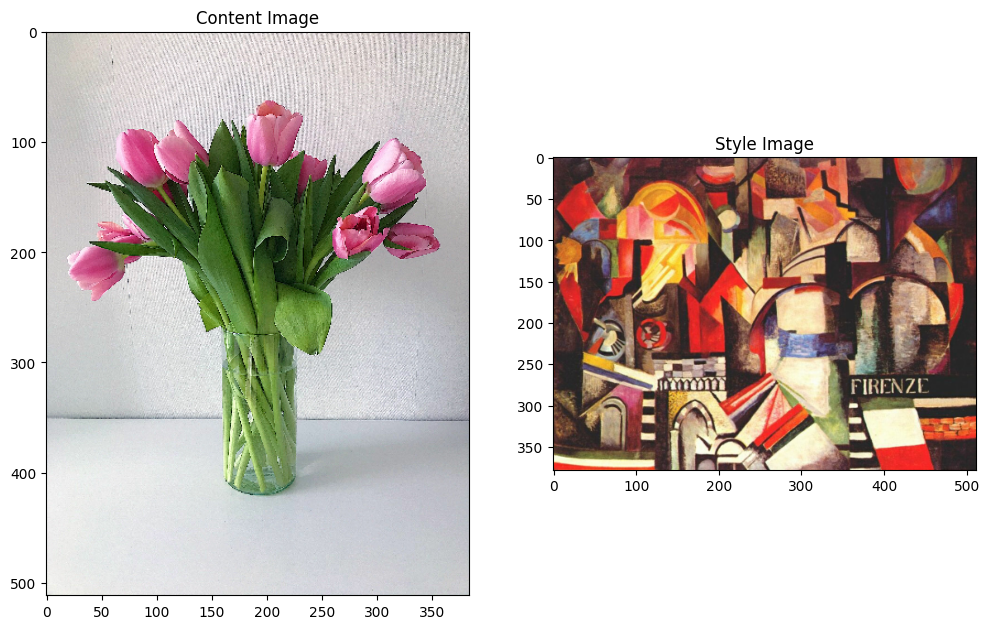

In [ ]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

### Вибір проміжних шарів для представлення стилю і змісту зображення

In [ ]:
content_layers = ['block5_conv2']

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

### Побудова моделі

In [ ]:
def vgg_layers(layer_names):
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  outputs = [vgg.get_layer(name).output for name in layer_names]
  model = tf.keras.Model([vgg.input], outputs)
  return model

In [ ]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

In [ ]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

In [ ]:
extractor = StyleContentModel(style_layers, content_layers)

80134624/80134624 [==============================] - 0s 0us/step


### Виконання градієнтного спуску

In [ ]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [ ]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [ ]:
style_weight=1e-2
content_weight=1e4

In [ ]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

### Навчання моделі

In [ ]:
total_variation_weight=30

In [ ]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
image = tf.Variable(content_image)

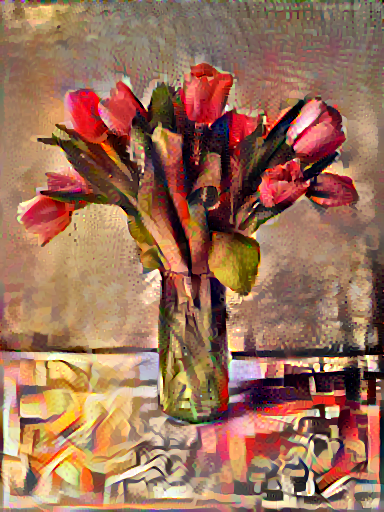

Train step: 1000


In [ ]:
epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))